In [38]:
import mne
import yasa
import numpy as np
import scipy as sp
import eeglabio
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
fname = '/Users/idohaber/test_data/Strength_101_N1_forSW.set'
raw = mne.io.read_raw_eeglab(fname, preload=True)   
raw

Reading /Users/idohaber/test_data/Strength_101_N1_forSW.fdt
Reading 0 ... 9297824  =      0.000 ... 18595.648 secs...


<RawEEGLAB | Strength_101_N1_forSW.fdt, 198 x 9297825 (18595.7 s), ~13.72 GiB, data loaded>

In [3]:
data = raw.get_data(units="uV")
sf = raw.info['sfreq']
chan = raw.ch_names


print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')
print('Data shape =', data.shape)
print('Duration =', data.shape[1] / sf, 'seconds')

Chan = ['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E11', 'E14', 'E15', 'E16', 'E17', 'E18', 'E22', 'E23', 'E24', 'E25', 'E27', 'E29', 'E30', 'E31', 'E32', 'E36', 'E37', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E60', 'E61', 'E62', 'E68', 'E73', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E85', 'E86', 'E87', 'E88', 'E89', 'E91', 'E92', 'E93', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E109', 'E110', 'E111', 'E112', 'E113', 'E114', 'E117', 'E118', 'E119', 'E120', 'E121', 'E122', 'E123', 'E124', 'E125', 'E126', 'E127', 'E128', 'E129', 'E130', 'E131', 'E132', 'E133', 'E134', 'E135', 'E136', 'E137', 'E138', 'E139', 'E140', 'E141', 'E142', 'E143', 'E144', 'E145', 'E146', 'E147', 'E148', 'E149', 'E150', 'E151', 'E152', 'E153', 'E154', 'E155', 'E156', 'E157', 'E158', 'E159', 'E162', 'E163', 'E165', 'E166', 'E167', 'E168', 'E171', 'E172', 'E174', 'E175', 'E176', 'E177', 'E178', 'E179', 'E180', '

In [4]:
start_time = 100
end_time  = 200
start_sample = int(start_time * sf)
end_sample = int(end_time * sf)

test_data = data[:, start_sample:end_sample]
print("Test Data shape:", test_data.shape)
print("Test Data duration", test_data.shape[1] / sf, "seconds")


Test Data shape: (198, 50000)
Test Data duration 100.0 seconds


In [27]:
events = mne.events_from_annotations(raw)  # raw events
events_id = events[-1]                     # grab event dict
actual_events = events[:-1][0]             # grab actual events
print(events_id, '\n') 
print(actual_events)

Used Annotations descriptions: ['stim end', 'stim start']
{'stim end': 1, 'stim start': 2} 

[[ 285418       0       2]
 [ 393453       0       1]
 [ 650362       0       2]
 [ 753307       0       1]
 [1008385       0       2]
 [1116421       0       1]
 [1364397       0       2]
 [1472438       0       1]
 [1718560       0       2]
 [1823876       0       1]
 [2007282       0       2]
 [2096473       0       1]
 [2391095       0       2]
 [2498220       0       1]
 [2774414       0       2]
 [2882458       0       1]
 [3302843       0       2]
 [3410881       0       1]
 [3717432       0       2]
 [3810466       0       1]]


In [36]:

sns.set(style="white", context="talk")

# Suppose you already have 'raw' loaded with your annotations
# and 'chan' is the list of channel names.
# events_from_annotations returns (events, event_id).

events, event_id = mne.events_from_annotations(raw)
print("Event dictionary:", event_id)  
# e.g., {'stim end': 1, 'stim start': 2}

stim_start_id = event_id["stim start"]  # = 2
stim_end_id   = event_id["stim end"]    # = 1

# Extract sample indices for stim start and stim end
start_indices = [ev[0] for ev in events if ev[2] == stim_start_id]
end_indices   = [ev[0] for ev in events if ev[2] == stim_end_id]

start_indices.sort()
end_indices.sort()

# Safety check (optional): they should come in pairs
if len(start_indices) != len(end_indices):
    print("Warning: Mismatch in number of starts vs ends.")
    # Decide how to handle or skip unmatched events if needed.


Used Annotations descriptions: ['stim end', 'stim start']
Event dictionary: {'stim end': 1, 'stim start': 2}


In [47]:
def compute_psds_for_segment(raw, start_smp, end_smp, chan_name,
                             chan_list,
                             fmin=0.5,
                             fmax=30,
                             win_sec=4):
    """
    Extract data from `raw` between start_smp and end_smp (in samples),
    compute:
      - Welch PSD (0.5 - 30 Hz)
      - IRASA aperiodic PSD
      - IRASA periodic (oscillatory) PSD
    for the specified channel_name.

    Returns:
      freqs_welch, psd_welch_chan,
      freqs_irasa, psd_aperiodic_chan, psd_osc_chan
    """
    sf = raw.info['sfreq']
    # Safety check
    if chan_name not in chan_list:
        raise ValueError(f"Channel {chan_name} not found in channel list.")

    chan_idx = chan_list.index(chan_name)

    # ------------------------------------------------------------
    # 1) Extract data for this segment
    # ------------------------------------------------------------
    segment_data = raw.get_data(start=start_smp, stop=end_smp)  # shape: (n_channels, n_samples)

    # ------------------------------------------------------------
    # 2) Compute Welch PSD (full freq range)
    # ------------------------------------------------------------
    freqs_welch, psd_welch_all = welch(
        segment_data,
        fs=sf,
        nperseg=int(win_sec * sf)
    )
    # psd_welch_all: shape (n_channels, n_freqs)

    # Restrict Welch freq range to [fmin, fmax]
    mask_welch = (freqs_welch >= fmin) & (freqs_welch <= fmax)
    freqs_welch_slice = freqs_welch[mask_welch]
    psd_welch_chan = psd_welch_all[chan_idx, mask_welch]

    # ------------------------------------------------------------
    # 3) Compute IRASA for [fmin, fmax]
    # ------------------------------------------------------------
    freqs_irasa, psd_aperiodic, psd_osc = yasa.irasa(
        segment_data,
        sf,
        ch_names=chan_list,
        band=(fmin, fmax),
        win_sec=win_sec,
        return_fit=False
    )
    # psd_aperiodic, psd_osc -> shape (n_channels, n_freqs_irasa)

    psd_aperiodic_chan = psd_aperiodic[chan_idx, :]
    psd_osc_chan       = psd_osc[chan_idx, :]

    return (freqs_welch_slice,
            psd_welch_chan,
            freqs_irasa,
            psd_aperiodic_chan,
            psd_osc_chan)


In [48]:
def plot_protocol_vs_comparison(
    raw,
    start_indices,
    end_indices,
    chan_list,
    chan_name,
    protocol_idx,
    comparison="post",   # "pre" or "post"
    fmin=0.5,
    fmax=30,
    win_sec=4
):
    """
    For the given protocol_idx, compute PSDs for:
      1) The protocol window (stim start -> stim end)
      2) A matched-length comparison window (pre or post)

    Then produce 3 subplots with overlayed lines:
      - Welch PSD
      - Aperiodic PSD (IRASA)
      - Periodic PSD (IRASA)

    Each subplot shows both the stim (protocol) and the comparison data.
    """

    sns.set(style="white", context="talk")

    # Check protocol_idx validity
    if protocol_idx >= len(start_indices) or protocol_idx >= len(end_indices):
        raise IndexError(f"protocol_idx={protocol_idx} out of range.")

    # Extract protocol start/end
    start_smp = start_indices[protocol_idx]
    end_smp   = end_indices[protocol_idx]
    if end_smp <= start_smp:
        raise ValueError(f"Invalid start/end samples: {start_smp}, {end_smp}")

    # --- Compute PSDs for PROTOCOL
    freqs_welch_stim, psd_welch_stim, \
    freqs_irasa_stim, psd_ap_stim, psd_osc_stim = compute_psds_for_segment(
        raw, start_smp, end_smp, chan_name,
        chan_list=chan_list,
        fmin=fmin,
        fmax=fmax,
        win_sec=win_sec
    )

    # --- Identify comparison window of same duration
    proto_dur = end_smp - start_smp  # in samples
    n_times = raw.n_times            # total samples in raw

    if comparison.lower() == "pre":
        comp_end = start_smp
        comp_start = comp_end - proto_dur
        if comp_start < 0:
            raise ValueError("Not enough data before the protocol start for a 'pre' comparison.")
    elif comparison.lower() == "post":
        comp_start = end_smp
        comp_end   = comp_start + proto_dur
        if comp_end > n_times:
            raise ValueError("Not enough data after the protocol end for a 'post' comparison.")
    else:
        raise ValueError("comparison must be 'pre' or 'post'.")

    # --- Compute PSDs for COMPARISON
    freqs_welch_comp, psd_welch_comp, \
    freqs_irasa_comp, psd_ap_comp, psd_osc_comp = compute_psds_for_segment(
        raw, comp_start, comp_end, chan_name,
        chan_list=chan_list,
        fmin=fmin,
        fmax=fmax,
        win_sec=win_sec
    )

    # --- Create 3 subplots: PSD, Aperiodic, Periodic
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(
        f"Protocol #{protocol_idx} ({start_smp}–{end_smp}) vs. {comparison.capitalize()} ({comp_start}–{comp_end})"
        f"\nChannel: {chan_name}",
        fontsize=16
    )

    # ========== (1) Welch PSD Overlay ==========
    ax0 = axes[0]
    ax0.plot(freqs_welch_stim, psd_welch_stim, color='C0', lw=2, label="Stim Protocol")
    ax0.plot(freqs_welch_comp, psd_welch_comp, color='C1', lw=2, label=f"{comparison.capitalize()} Compare")
    ax0.set_title("Total PSD (Welch)", fontsize=14)
    ax0.set_xlabel("Frequency [Hz]")
    ax0.set_ylabel("PSD [uV^2/Hz]")
    ax0.set_xlim(fmin, fmax)
    ax0.set_yscale("log")
    ax0.legend()
    sns.despine(ax=ax0)

    # ========== (2) Aperiodic PSD Overlay ==========
    ax1 = axes[1]
    ax1.plot(freqs_irasa_stim, psd_ap_stim, color='C0', lw=2, label="Stim Protocol")
    ax1.plot(freqs_irasa_comp, psd_ap_comp, color='C1', lw=2, label=f"{comparison.capitalize()} Compare")
    ax1.set_title("Aperiodic PSD (IRASA)", fontsize=14)
    ax1.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("PSD [uV^2/Hz]")
    ax1.set_xlim(fmin, fmax)
    ax1.set_yscale("log")
    ax1.legend()
    sns.despine(ax=ax1)

    # ========== (3) Periodic PSD Overlay ==========
    ax2 = axes[2]
    ax2.plot(freqs_irasa_stim, psd_osc_stim, color='C0', lw=2, label="Stim Protocol")
    ax2.plot(freqs_irasa_comp, psd_osc_comp, color='C1', lw=2, label=f"{comparison.capitalize()} Compare")
    ax2.set_title("Periodic PSD (IRASA)", fontsize=14)
    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("PSD [uV^2/Hz]")
    ax2.set_xlim(fmin, fmax)
    # For periodic PSD, you could also keep linear scale:
    # ax2.set_yscale("linear")
    # or log scale if you prefer:
    # ax2.set_yscale("log")
    ax2.legend()
    sns.despine(ax=ax2)

    plt.tight_layout()
    plt.show()


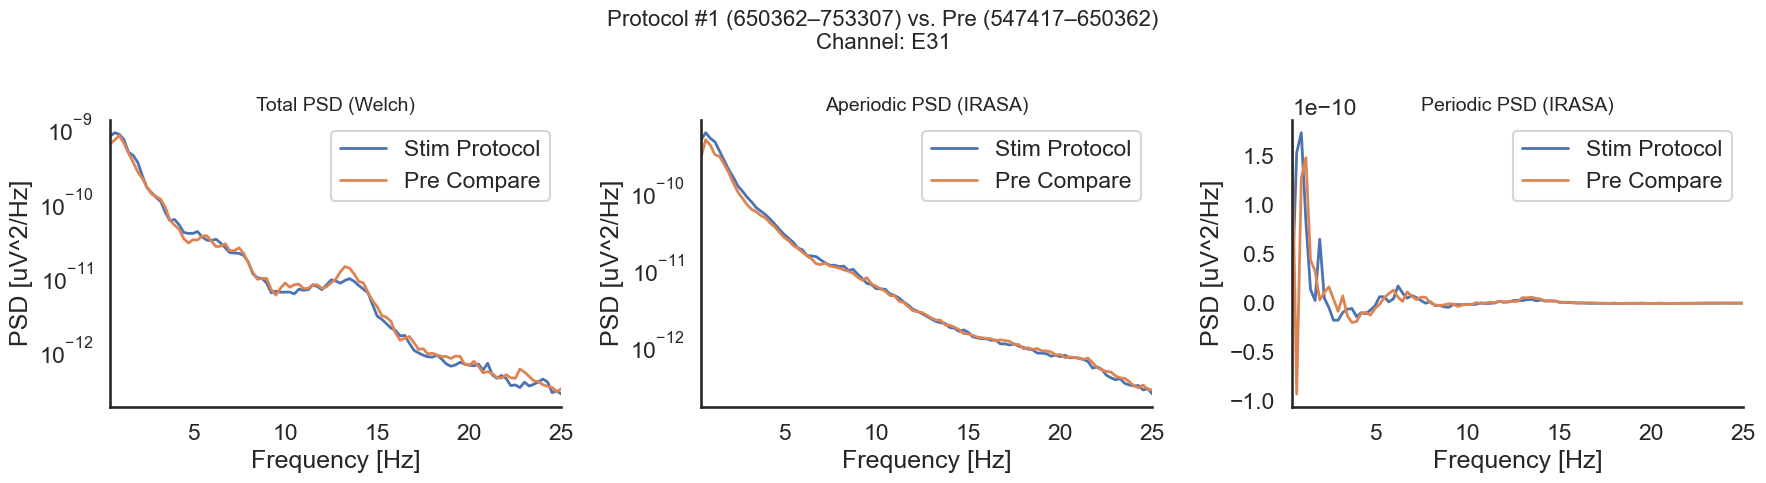

In [50]:
# After you’ve extracted the start_indices, end_indices
# (for stim start/end) from events, do something like:

chan_name = "E31"
protocol_idx = 1  # the first protocol in your list

# Compare this stim protocol to the "post" segment:
plot_protocol_vs_comparison(
    raw,
    start_indices,
    end_indices,
    chan_list=chan,   # your channel list
    chan_name=chan_name,
    protocol_idx=protocol_idx,
    comparison="pre",   # or "pre"
    fmin=0.5,
    fmax=25,
    win_sec=4
)
